In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
import scipy.signal
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Global parameters
This cell (below) enlists user-defined parameters

In [2]:
# colours is a vector of BGR values which are used to identify individuals in the video
# since we only have one individual, the program will only use the first element from this array i.e. (0,0,255) - red
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
n_inds = 1
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 71
offset = 15

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
min_area = 100
max_area = 1000

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = False

# name of source video and paths
video = 'flume_video'
input_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/videos/' + video + '.mp4'
output_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/output/' + video + '.mp4'
output_filepath = '/mnt/ssd1/Documents/Vivek/tracktor/output/' + video + '.csv'
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

The cell below runs the tracking code

In [3]:
## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 30.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

last = 0
df = []

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    this = cap.get(1)
    if ret == True:
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        
        # Apply mask to aarea of interest
        mask = np.zeros(frame.shape)
        mask = cv2.rectangle(mask, (280, 3), (1030,690), (255,255,255), -1)
        frame[mask ==  0] = 0
        
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)
        
        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1]])
        
        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
    if last == this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Summary statistics
The cells below provide functions to perform basic summary statistics - in this case, time spent in a user-defined region of interest.

In [13]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y
0,0,3.0,962.256573,231.895070
1,1,4.0,962.300353,231.945112
2,2,5.0,962.326719,231.978975
3,3,6.0,962.226799,231.568182
4,4,7.0,962.134702,231.304789


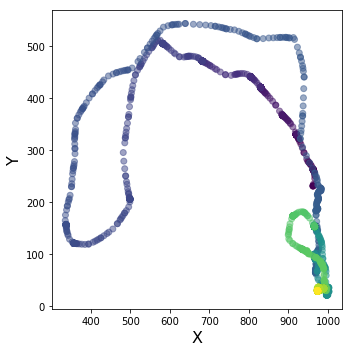

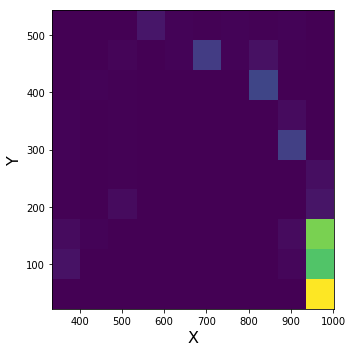

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(df['pos_x'], df['pos_y'], c=df['frame'], alpha=0.5)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex2_fig1a.eps', format='eps', dpi=300)
plt.show()

plt.figure(figsize=(5,5))
plt.hist2d(df['pos_x'], df['pos_y'], bins=10)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex2_fig1b.eps', format='eps', dpi=300)
plt.show()

In [5]:
cap = cv2.VideoCapture(input_vidpath)
ret, img = cap.read()

## Select ROI on image and press enter (roi is a tuple of format: x0, y0, width, height)
roi = cv2.selectROI('test', img)

In [6]:
## Get proportion of total time spent in selected ROI
prop = len(df[(df['pos_x'] > roi[0]) & (df['pos_x'] < roi[0]+roi[2]) & (df['pos_y'] > roi[1]) & (df['pos_y'] < roi[1]+roi[3])]) / len(df)
print('----- The fish spent ' + str(prop*100) + '% of its time in the selected region of interest -----')

----- The fish spent 90.4896013864818% of its time in the selected region of interest -----
